In [1]:
import ARESlatticeStage3v1_9 as ares
import cheetah
import matplotlib.pyplot as plt
import torch

[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.


initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation


### Loading the lattice

The lattice is available in Ocelot's format, so we use the `from_ocelot` class method of `Segement`. Because we only care about the Experimental Area (EA), we then select a subcell of the lattice file of the entire ARES accelerator.

Unlike Cheetah, Ocelot does not support screens. Therefore, when Oceloet `Marker`s have the substiring `"screen"` in their name, Cheetah creates a `Screen` element with default properties and emits a warning about this. We can than manually set the correct screen properties.


In [2]:
segment = cheetah.Segment.from_ocelot(ares.cell).subcell(
    "AREASOLA1", "AREABSCR1"
)

# Manually set screen properties
segment.AREABSCR1.resolution = torch.tensor((2448, 2040), dtype=torch.float32)
segment.AREABSCR1.pixel_size = torch.tensor((3.3198e-6, 2.4469e-6), dtype=torch.float32)

# Set some values on the magnets
segment.AREAMQZM1.k1 = torch.tensor(10.0, dtype=torch.float32)
segment.AREAMQZM2.k1 = torch.tensor(-9.0, dtype=torch.float32)
segment.AREAMCVM1.angle = torch.tensor(1e-3, dtype=torch.float32)
segment.AREAMQZM3.k1 = torch.tensor(-8.0, dtype=torch.float32)
segment.AREAMCHM1.angle = torch.tensor(-2e-3, dtype=torch.float32)

segment

/opt/homebrew/Caskroom/miniforge/base/envs/cheetah-demos/lib/python3.13/site-packages/cheetah/accelerator/segment.py:330: DefaultParameterWarning: Diagnostic screen was converted with default screen properties.
  ocelot.convert_element_to_cheetah(


Segment(elements=ModuleList(
  (0): Marker(name='AREASOLA1')
  (1): Drift(length=tensor(0.1750), tracking_method='cheetah', name='Drift_AREASOLA1')
  (2): Quadrupole(length=tensor(0.1220), k1=tensor(10.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM1')
  (3): Drift(length=tensor(0.4280), tracking_method='cheetah', name='Drift_AREAMQZM1')
  (4): Quadrupole(length=tensor(0.1220), k1=tensor(-9.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM2')
  (5): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMQZM2')
  (6): VerticalCorrector(length=tensor(0.0200), angle=tensor(0.0010), name='AREAMCVM1')
  (7): Drift(length=tensor(0.2040), tracking_method='cheetah', name='Drift_AREAMCVM1')
  (8): Quadrupole(length=tensor(0.1220), k1=tensor(-8.), misalignment=tensor([0., 0.]), tilt=tensor(0.), num_steps=1, tracking_method='cheetah', name='AREAMQZM3')
  (9): Drift(l

### Load particle distribution

We load the beam both as a `ParameterBeam` and a `ParticleBeam` in order to test Cheetah's speed in both its fastest as well as its full particle tracking mode.


In [3]:
parameter_beam = cheetah.ParameterBeam.from_astra(
    "ACHIP_EA1_2021.1351.001", device="cpu"
)
parameter_beam

ParameterBeam(mu=tensor([ 8.2413e-07,  5.9885e-08, -1.7276e-06, -1.1746e-07,  5.7250e-06,
         3.8292e-04,  1.0000e+00]), cov=tensor([[ 3.0589e-08,  5.5679e-10,  8.0207e-13,  2.2111e-13, -6.3953e-13,
         -7.6916e-12,  0.0000e+00],
        [ 5.5679e-10,  1.3538e-11,  9.8643e-14,  6.4855e-15, -3.6896e-14,
         -8.0708e-14,  0.0000e+00],
        [ 8.0207e-13,  9.8643e-14,  3.0693e-08,  5.6076e-10,  6.0425e-13,
          3.3948e-11,  0.0000e+00],
        [ 2.2111e-13,  6.4855e-15,  5.6076e-10,  1.3646e-11,  6.4452e-14,
          5.3652e-12,  0.0000e+00],
        [-6.3953e-13, -3.6896e-14,  6.0425e-13,  6.4452e-14,  6.4185e-11,
          3.0040e-09,  0.0000e+00],
        [-7.6916e-12, -8.0708e-14,  3.3948e-11,  5.3652e-12,  3.0040e-09,
          5.2005e-06,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), energy=tensor(1.0732e+08), total_charge=tensor(5.0000e-13), s=tensor(0.), species=Species(name='el

In [4]:
particle_beam = cheetah.ParticleBeam.from_astra("ACHIP_EA1_2021.1351.001", device="cpu")
particle_beam

ParticleBeam(particles=tensor([[ 5.0896e-08,  5.9917e-09, -5.4731e-07,  ..., -0.0000e+00,
          2.2205e-16,  1.0000e+00],
        [ 6.1503e-05,  6.2810e-07, -5.5022e-07,  ...,  2.1870e-06,
         -1.0257e-03,  1.0000e+00],
        [ 2.3025e-08,  6.3879e-09,  4.4044e-05,  ...,  6.8509e-07,
          1.1856e-03,  1.0000e+00],
        ...,
        [ 2.0862e-04,  5.5063e-06,  2.0189e-04,  ...,  8.3149e-07,
         -5.4731e-04,  1.0000e+00],
        [ 5.6475e-05,  1.2176e-06,  2.7788e-04,  ...,  1.1890e-06,
          1.4368e-03,  1.0000e+00],
        [-6.2661e-05, -2.3784e-06,  2.1643e-04,  ...,  6.5793e-06,
         -1.8158e-03,  1.0000e+00]]), energy=107315904.0, particle_charges=tensor([5.0000e-18, 5.0000e-18, 5.0000e-18,  ..., 5.0000e-18, 5.0000e-18,
        5.0000e-18]), survival_probabilities=tensor([1., 1., 1.,  ..., 1., 1., 1.]), s=0.0, species=Species(name='electron', num_elementary_charges=tensor(-1), mass_eV=tensor(510998.9375)))

In [5]:
particle_beam_10m = cheetah.ParticleBeam.from_parameters(
    num_particles=10_000_000,
    mu_x=particle_beam.mu_x,
    mu_y=particle_beam.mu_y,
    mu_px=particle_beam.mu_px,
    mu_py=particle_beam.mu_py,
    sigma_x=particle_beam.sigma_x,
    sigma_y=particle_beam.sigma_y,
    sigma_px=particle_beam.sigma_px,
    sigma_py=particle_beam.sigma_py,
    sigma_tau=particle_beam.sigma_tau,
    sigma_p=particle_beam.sigma_p,
    # cor_x=particle_beam.cor_x,
    # cor_y=particle_beam.cor_y,
    # cor_tau=particle_beam.cor_tau,
    energy=particle_beam.energy,
    total_charge=particle_beam.total_charge,
    device=particle_beam.particles.device,
    dtype=particle_beam.particles.dtype,
)
particle_beam_10m

ParticleBeam(particles=tensor([[ 2.7265e-04, -4.6334e-06,  7.6674e-05,  ...,  2.0302e-06,
          1.0566e-03,  1.0000e+00],
        [-4.4610e-05,  3.0028e-06, -6.8614e-05,  ..., -1.7622e-06,
         -2.6744e-04,  1.0000e+00],
        [ 5.9648e-05, -2.8283e-07,  3.6053e-04,  ...,  4.8036e-06,
         -2.0739e-03,  1.0000e+00],
        ...,
        [-1.2123e-04, -3.7300e-06, -1.4106e-04,  ..., -8.1808e-06,
          2.1030e-03,  1.0000e+00],
        [-7.7051e-05,  4.4461e-06, -7.9217e-05,  ...,  1.2682e-05,
          2.6448e-03,  1.0000e+00],
        [ 2.7039e-04,  5.0316e-06,  2.4954e-06,  ...,  1.5338e-05,
          1.6441e-03,  1.0000e+00]]), energy=107315904.0, particle_charges=tensor([5.0000e-20, 5.0000e-20, 5.0000e-20,  ..., 5.0000e-20, 5.0000e-20,
        5.0000e-20]), survival_probabilities=tensor([1., 1., 1.,  ..., 1., 1., 1.]), s=0.0, species=Species(name='electron', num_elementary_charges=tensor(-1), mass_eV=tensor(510998.9375)))

### Benchmark

We first start with a simple benchmark just tracking particles.


In [6]:
optimized_segment = segment.transfer_maps_merged(incoming_beam=particle_beam)

#### Parameter Beam


In [7]:
segment.AREABSCR1.is_active = False

In [8]:
%%timeit
outgoing = segment.track(parameter_beam)

1.06 ms ± 19.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
%%timeit
outgoing = optimized_segment.track(parameter_beam)

39.4 μs ± 115 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
outgoing = segment.track(parameter_beam)
outgoing

ParameterBeam(mu=tensor([-9.0040e-04, -2.0006e-03,  7.9550e-04,  7.4922e-04,  5.7072e-06,
         3.8292e-04,  1.0000e+00]), cov=tensor([[ 1.3705e-08,  1.7307e-08, -8.7002e-14,  5.7429e-13,  3.4064e-13,
          5.3441e-12,  0.0000e+00],
        [ 1.7307e-08,  2.1863e-08, -1.1730e-13,  9.6521e-13,  4.6839e-13,
          6.6667e-12,  0.0000e+00],
        [-8.7002e-14, -1.1730e-13,  8.4647e-11, -3.0361e-09,  6.0675e-14,
          4.3783e-12,  0.0000e+00],
        [ 5.7429e-13,  9.6521e-13, -3.0361e-09,  1.1013e-07, -1.1828e-12,
         -6.7982e-11,  0.0000e+00],
        [ 3.4064e-13,  4.6839e-13,  6.0675e-14, -1.1828e-12,  6.3917e-11,
          2.7627e-09,  0.0000e+00],
        [ 5.3441e-12,  6.6667e-12,  4.3783e-12, -6.7982e-11,  2.7627e-09,
          5.2005e-06,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), energy=tensor(1.0732e+08), total_charge=tensor(5.0000e-13), s=tensor(2.0460), species=Species(name

We continue with a benchmark tracking particles and then reading the screen.


In [11]:
segment.AREABSCR1.is_active = True

In [12]:
%%timeit
outgoing = segment.track(parameter_beam)
img = segment.AREABSCR1.reading

24.5 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


ParameterBeam(mu=tensor([-9.0040e-04, -2.0006e-03,  7.9550e-04,  7.4922e-04,  5.7072e-06,
         3.8292e-04,  1.0000e+00]), cov=tensor([[ 1.3705e-08,  1.7307e-08, -8.7002e-14,  5.7429e-13,  3.4064e-13,
          5.3441e-12,  0.0000e+00],
        [ 1.7307e-08,  2.1863e-08, -1.1730e-13,  9.6521e-13,  4.6839e-13,
          6.6667e-12,  0.0000e+00],
        [-8.7002e-14, -1.1730e-13,  8.4647e-11, -3.0361e-09,  6.0675e-14,
          4.3783e-12,  0.0000e+00],
        [ 5.7429e-13,  9.6521e-13, -3.0361e-09,  1.1013e-07, -1.1828e-12,
         -6.7982e-11,  0.0000e+00],
        [ 3.4064e-13,  4.6839e-13,  6.0675e-14, -1.1828e-12,  6.3917e-11,
          2.7627e-09,  0.0000e+00],
        [ 5.3441e-12,  6.6667e-12,  4.3783e-12, -6.7982e-11,  2.7627e-09,
          5.2005e-06,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), energy=tensor(1.0732e+08), total_charge=tensor(5.0000e-13), s=tensor(2.0460), species=Species(name

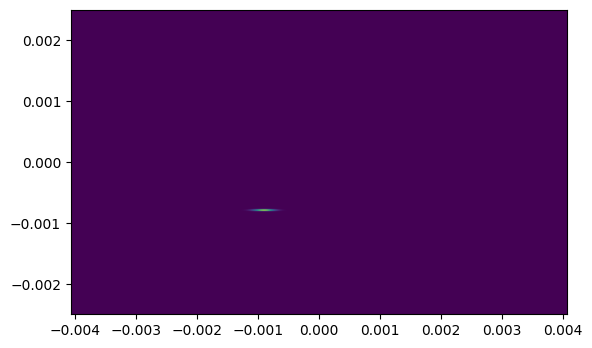

In [13]:
outgoing = segment.track(parameter_beam)
img = segment.AREABSCR1.reading

print(outgoing)  # Should be an empty beam because it is blocked by the screen

plt.imshow(img.numpy(), extent=segment.AREABSCR1.extent.numpy())
plt.show()

#### Particle Beam


In [14]:
segment.AREABSCR1.is_active = False

In [15]:
%%timeit
outgoing = segment.track(particle_beam)

2.07 ms ± 108 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
outgoing = optimized_segment.track(particle_beam)

970 μs ± 71.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
%%timeit
outgoing = segment.track(particle_beam_10m)

43.2 ms ± 243 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit
outgoing = optimized_segment.track(particle_beam_10m)

41.8 ms ± 218 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
outgoing = segment(particle_beam)
outgoing

ParticleBeam(particles=tensor([[-9.0002e-04, -2.0000e-03,  7.9561e-04,  ..., -1.0301e-20,
          2.2205e-16,  1.0000e+00],
        [-9.4279e-04, -2.0534e-03,  7.9561e-04,  ...,  2.2345e-06,
         -1.0257e-03,  1.0000e+00],
        [-8.9999e-04, -2.0000e-03,  7.9759e-04,  ...,  6.3009e-07,
          1.1856e-03,  1.0000e+00],
        ...,
        [-1.0336e-03, -2.1714e-03,  8.0746e-04,  ...,  8.5688e-07,
         -5.4731e-04,  1.0000e+00],
        [-9.3710e-04, -2.0472e-03,  8.1167e-04,  ...,  1.1224e-06,
          1.4368e-03,  1.0000e+00],
        [-8.6236e-04, -1.9506e-03,  8.0836e-04,  ...,  6.6636e-06,
         -1.8158e-03,  1.0000e+00]]), energy=107315904.0, particle_charges=tensor([5.0000e-18, 5.0000e-18, 5.0000e-18,  ..., 5.0000e-18, 5.0000e-18,
        5.0000e-18]), survival_probabilities=tensor([1., 1., 1.,  ..., 1., 1., 1.]), s=2.0460398197174072, species=Species(name='electron', num_elementary_charges=tensor(-1), mass_eV=tensor(510998.9375)))

We continue with a benchmark tracking particles and then reading the screen.


In [20]:
segment.AREABSCR1.is_active = True

In [21]:
%%timeit
outgoing = segment.track(particle_beam)
img = segment.AREABSCR1.reading

14.2 ms ± 463 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit
outgoing = segment.track(particle_beam_10m)
img = segment.AREABSCR1.reading

172 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


ParticleBeam(particles=tensor([[-9.0002e-04, -2.0000e-03,  7.9561e-04,  ..., -1.0301e-20,
          2.2205e-16,  1.0000e+00],
        [-9.4279e-04, -2.0534e-03,  7.9561e-04,  ...,  2.2345e-06,
         -1.0257e-03,  1.0000e+00],
        [-8.9999e-04, -2.0000e-03,  7.9759e-04,  ...,  6.3009e-07,
          1.1856e-03,  1.0000e+00],
        ...,
        [-1.0336e-03, -2.1714e-03,  8.0746e-04,  ...,  8.5688e-07,
         -5.4731e-04,  1.0000e+00],
        [-9.3710e-04, -2.0472e-03,  8.1167e-04,  ...,  1.1224e-06,
          1.4368e-03,  1.0000e+00],
        [-8.6236e-04, -1.9506e-03,  8.0836e-04,  ...,  6.6636e-06,
         -1.8158e-03,  1.0000e+00]]), energy=107315904.0, particle_charges=tensor([5.0000e-18, 5.0000e-18, 5.0000e-18,  ..., 5.0000e-18, 5.0000e-18,
        5.0000e-18]), survival_probabilities=tensor([1., 1., 1.,  ..., 1., 1., 1.]), s=2.0460398197174072, species=Species(name='electron', num_elementary_charges=tensor(-1), mass_eV=tensor(510998.9375)))


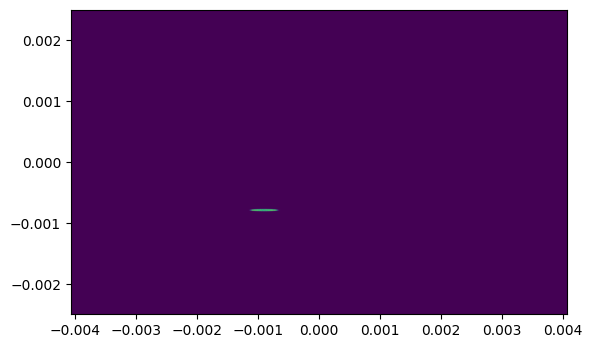

In [23]:
outgoing = segment.track(particle_beam)
img = segment.AREABSCR1.reading

print(outgoing)  # Should be an empty beam because it is blocked by the screen

plt.imshow(img.numpy(), extent=segment.AREABSCR1.extent.numpy())
plt.show()